In [2]:
import pickle as pkl
import numpy as np
from collections import defaultdict

In [3]:
def _group_videos_by_video_id(data):
    video_groups = defaultdict(list)
    for sample in data:
        video_id = sample[0]
        video_groups[video_id].append(sample)
    for video_id in video_groups:
        video_groups[video_id].sort(key=lambda x: float(x[1]))
    return video_groups

In [4]:
data_path = "/dais/fs/scratch/dduka/databases/ego4d/ego4d_train.pkl"
pseudolables_path = "/dais/fs/scratch/dduka/databases/ego4d/ego4d_train_uncovered_all.narrator_63690737.return_5_enriched.pkl"

In [5]:
with open(data_path, 'rb') as f:
    data = pkl.load(f)

with open(pseudolables_path, 'rb') as f:
    pseudolabels_data = pkl.load(f)

data = _group_videos_by_video_id(data)
pseudolabels = _group_videos_by_video_id(pseudolabels_data)

In [6]:
video_id = list(data.keys())[0]
print(f"Video ID: {video_id}")
segments = [(s[1], s[2]) for s in data[video_id]]
pseudo_segments = [(s[1], s[2]) for s in pseudolabels[video_id]]

Video ID: 9e4edf4d-e557-4b3d-bc35-0d7f1f91019b


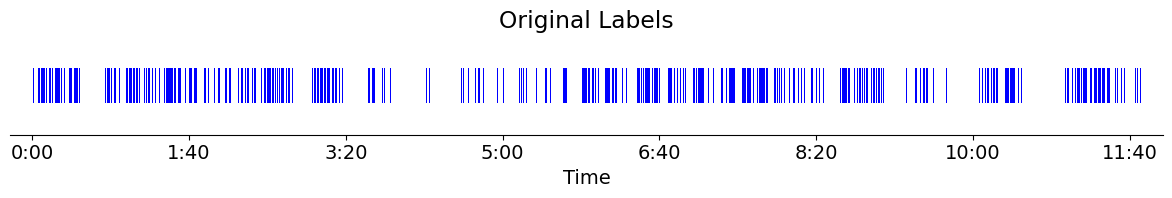

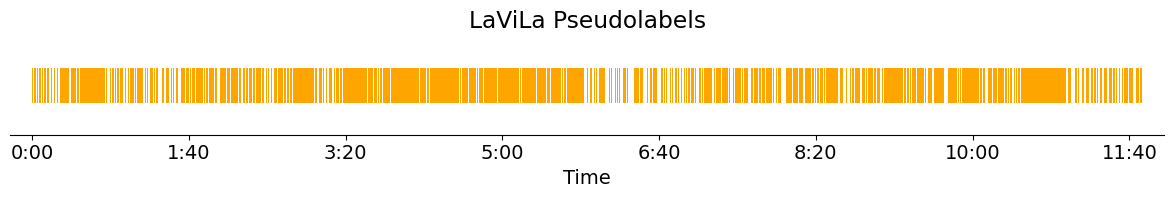

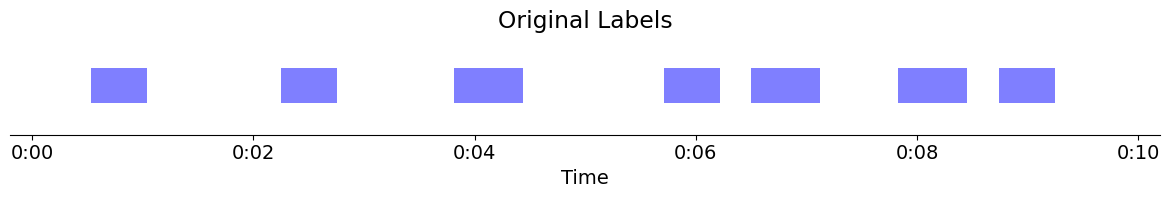

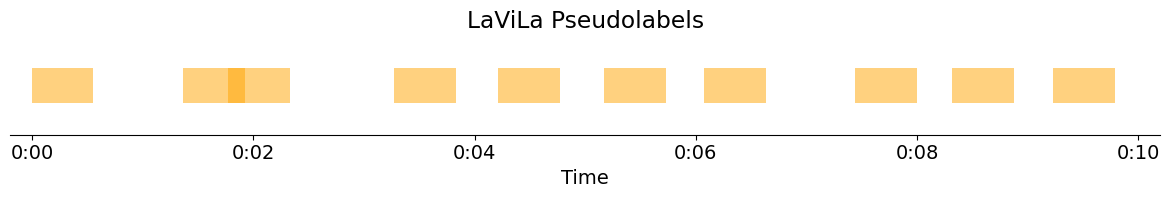

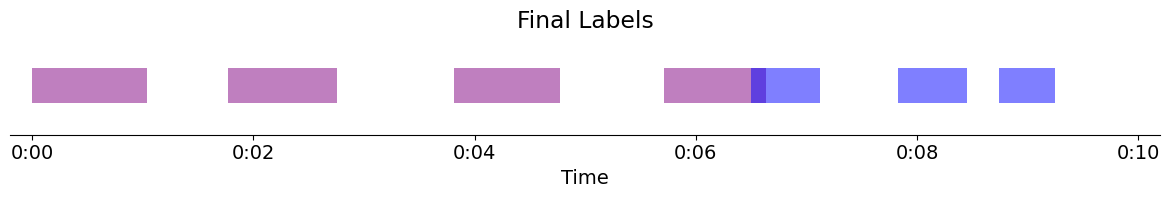

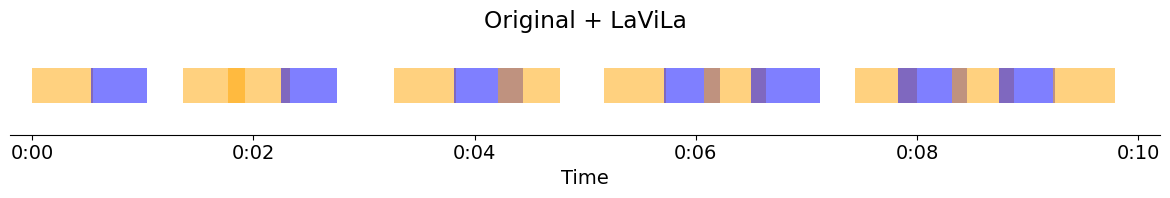

In [72]:
from typing import Iterable, Any
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

# ↑ NEW: increase default font size for everything
plt.rcParams.update({"font.size": 14})

# --- unchanged helper ---
def _parse_ts(ts: "TS") -> float:
    """Accepts seconds (int/float) or 'HH:MM:SS' / 'MM:SS' / 'SS' strings. Returns seconds (float)."""
    if isinstance(ts, (int, float)):
        return float(ts)
    if isinstance(ts, str):
        parts = [p.strip() for p in ts.split(":")]
        vals = [float(p) for p in parts]
        if len(vals) == 1:
            s = vals[0]
        elif len(vals) == 2:
            m, s = vals; s += 60*m
        elif len(vals) == 3:
            h, m, s = vals; s += 60*(m + 60*h)
        else:
            raise ValueError(f"Bad timestamp: {ts!r}")
        return float(s)
    raise TypeError(f"Unsupported timestamp type: {type(ts)}")


def _unique_covered_seconds(segs_num: list[tuple[float, float] | tuple[float, float, Any]]) -> float:
    """Sum of union of segments (ignoring overlaps and colors). Accepts 2- or 3-tuples."""
    if not segs_num:
        return 0.0
    # normalize to (start, end)
    intervals = [(s, e) if len(t) == 2 else (t[0], t[1]) for t in segs_num]
    intervals = sorted(intervals, key=lambda t: (t[0], t[1]))

    cs, ce = intervals[0]
    total = 0.0
    for s, e in intervals[1:]:
        if s <= ce:
            ce = max(ce, e)
        else:
            total += ce - cs
            cs, ce = s, e
    total += ce - cs
    return total


def make_timeline_title(
    segments: Iterable["Segment"],
    *,
    video_id=None,
    label="Segments",
    total: "TS | None" = None,
    include_icons: bool = True,
) -> str:
    """Build a compact, informative title for your timeline plot."""
    segs = [(_parse_ts(s), _parse_ts(e), color) for s, e, color in segments]
    if any(e <= s for s, e, _ in segs):
        raise ValueError("Each segment must have positive duration (end > start).")

    n = len(segs)
    max_end = max(e for _, e, __ in segs)
    T = _parse_ts(total) if total is not None else max_end

    covered = _unique_covered_seconds(segs)
    coverage_pct = (covered / T * 100) if T > 0 else 0.0

    # Keep it simple; you can customize as you like.
    return f"{label}"


def plot_video_bar(
    segments: Iterable["Segment"],
    *,
    total: "TS | None" = None,     # total video length (seconds or 'HH:MM:SS'); if None uses max end
    bar_height: float = 0.35,      # thickness of the single bar (in y-data units)
    basecolor: str = "#e6e6e6",    # base bar color
    facecolor: str = "tab:blue",   # fallback color if a segment color is None
    edgecolor: str = "black",      # stroke for segments
    linewidth: float = 1.5,        # stroke width
    title: str = "Timeline",
    zero_origin: bool = True,       # start x-axis at 0s
    alpha: float = 1.0
):
    """Plot a one-row timeline bar with colored segments. Segments are (start, end, color)."""
    segs = sorted(
        [(_parse_ts(s), _parse_ts(e), color) for s, e, color in segments],
        key=lambda t: t[0]
    )
    if not segs:
        raise ValueError("segments must be a non-empty list of (start, end, color) tuples.")
    if any(e <= s for s, e, _ in segs):
        raise ValueError("Each segment must have positive duration (end > start).")

    min_start = min(s for s, _, __ in segs)
    max_end = max(e for _, e, __ in segs)
    T = _parse_ts(total) if total is not None else max_end

    # One axes, one horizontal bar
    fig, ax = plt.subplots(figsize=(12, 2.2))
    y_center = 0.5
    bar_y = y_center - bar_height / 2.0

    # # # Base bar (full timeline)
    # ax.add_patch(
    #     Rectangle(
    #         (0 if zero_origin else min_start, bar_y),
    #         width=9.5,
    #         height=bar_height,
    #         facecolor=basecolor,
    #         edgecolor="none"
    #     )
    # )

    # Highlighted segments (per-segment color, with stroke)
    for s, e, color in segs:
        seg_color = color if color is not None else facecolor
        left = s if zero_origin else s
        ax.add_patch(
            Rectangle(
                (left, bar_y),
                width=e - s,
                height=bar_height,
                facecolor=seg_color,
                joinstyle="miter",
                capstyle="butt",
                alpha=alpha
            )
        )

    # Cosmetics: show only x-axis with HH:MM:SS ticks
    ax.set_ylim(0, 1)
    ax.set_yticks([])
    for spine in ("left", "right", "top"):
        ax.spines[spine].set_visible(False)

    def _fmt_hms(v: float) -> str:
        v = max(0.0, float(v))
        h = int(v // 3600); m = int((v % 3600) // 60); s = int(v % 60)
        if h > 0: return f"{h:d}:{m:02d}:{s:02d}"
        return f"{m:d}:{s:02d}"

    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, pos: _fmt_hms(v)))
    left = 0 if zero_origin else min_start
    right = max(T, max_end)
    span = max(1.0, right - left)
    pad = 0.02 * span
    ax.set_xlim(left - pad, right + pad)

    ax.set_xlabel("Time")
    ax.set_title(title)
    plt.tight_layout()
    return fig, ax

# --- usage with color in the tuples ---
segments = [(s[1], s[2], "blue") for s in data[video_id]]
captions = [s[3] for s in data[video_id]]
pseudo_segments = [(s[1], s[2], "orange") for s in pseudolabels[video_id]]
pseudo_captions = [s[3] for s in pseudolabels[video_id]]

total_duration = None
title1 = make_timeline_title(segments, video_id=video_id, label="Original Labels", total=total_duration)
title2 = make_timeline_title(pseudo_segments, video_id=video_id, label="LaViLa Pseudolabels", total=total_duration)

# if you still need a sorted list of (start,end) without color:
sorted_segments = sorted(((_parse_ts(s), _parse_ts(e)) for s, e, _ in (segments + pseudo_segments)), key=lambda t: t[0])

orig_fig, _ = plot_video_bar(segments, title=title1, total=total_duration)
pseudo_fig, _ = plot_video_bar(pseudo_segments, title=title2, total=total_duration)

orig_fig.savefig(f"{video_id}_original_segments.pdf")
pseudo_fig.savefig(f"{video_id}_pseudo_segments.pdf")

n = 10
end = segments[:n][-1][1]

segments = segments[:3] + segments[5:7] + segments[8:n]
pseudo_segments = pseudo_segments[:n]

zoomed_orig_fig, _ = plot_video_bar(segments, title=f"{title1}", total=10, alpha=0.5)
zoomed_pseudo_fig, _ = plot_video_bar(pseudo_segments, title=f"{title2}", total=10, alpha=0.5)

zoomed_both = [
    (pseudo_segments[0][0], segments[0][1], "purple"), 
    # pseudo_segments[1], 
    (pseudo_segments[2][0], segments[1][1], "purple"),
    # pseudo_segments[3],
    
    (segments[2][0], pseudo_segments[4][1], "purple"),
    # pseudo_segments[5],
    (segments[3][0], pseudo_segments[6][1], "purple"),
    segments[4],
    # (segments[5][0], pseudo_segments[7][1], "purple"), .
    segments[-2],
    segments[-1]
]

# zoomed_both = segments + pseudo_segments

# combined zoom (colors preserved)
zoomed_both_figsss, _ = plot_video_bar(
    zoomed_both,
    title=f"Final Labels", total=10, alpha=0.5
)

zoomed_both_fig, _ = plot_video_bar(
    segments + pseudo_segments,
    title=f"Original + LaViLa", total=10, alpha=0.5
)

zoomed_orig_fig.savefig(f"{video_id}_zoomed_original_segments.pdf")
zoomed_pseudo_fig.savefig(f"{video_id}_zoomed_pseudo_segments.pdf")
zoomed_both_fig.savefig(f"{video_id}_zoomed_both_segments.pdf")
zoomed_both_figsss.savefig(f"{video_id}_zoomed_both_segments_sss.pdf")

In [8]:
print(captions)
print(pseudo_captions)

['#C C fixes the camera', '#C C moves around the room', '#C C carries a pot from the cooker', '#C C drops the pot on the cooker', '#C C removes cooking pot from the gas cooker', '#C C places cooking in the next gas cooker', '#C C carries a sauce pan from the counter', '#C C picks a saucepan', '#C C drops the sauce pan on the cooker', '#C C places a saucepan in a gas cooker', '#C C turns on a light', '#C C put on the light', '#C C takes a bowl from the counter', '#C C picks the bowl', '#C C takes a sieve from the plate rack', '#C C picks a drainer', '#C C drops the sieve in the sink', '#C C places drainer in the sink', '#C C opens the cabinet', '#C C opens a cupboard', '#C C places the bowl in the cabinet', '#C C places the bowl in the cupboard', '#C C closes the cupboard', '#C C closes the cabinet', '#C C takes the cover from the pot', '#C C opens the cooking pot', '#C C takes the pot from the cooker', '#C C drops the pot cover on the cooker', '#C C places the lid on top of a gas cooke